In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score, pairwise_distances
from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
dat = pd.read_csv('data/data.csv', low_memory=False)

# Domain Specific Clusters (Subset datasets: 31 Questions in Total for 3 Clusters)

## Subset the combined dataset and process the data

### Subset and Process

In [3]:
# Define all index ranges and individual indices
mental_ix  = list(range(25, 30)) + [83, 105]
home_ix    = list(range(88, 91)) + list(range(98, 102)) + [103]
social_ix  = [13, 15, 18] + list(range(19, 25)) + [87, 102, 104]
health_ix  = list(range(75, 78)) + [84]

# Combine and sort unique indices
all_indices = sorted(set(mental_ix + home_ix + social_ix + health_ix))

# Subset columns by index
dat1 = dat.iloc[:, all_indices].copy()

In [4]:
num_rows_with_na = dat1.isna().any(axis=1).sum()
num_rows_with_na

np.int64(10900)

In [5]:
dat_cleaned = dat1.dropna(axis=0, how='any')
dat_cleaned.shape

(9203, 31)

In [6]:
dat_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9203 entries, 1 to 11426
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Q14     9203 non-null   float64
 1   Q16     9203 non-null   float64
 2   Q19     9203 non-null   float64
 3   Q20     9203 non-null   float64
 4   Q21     9203 non-null   float64
 5   Q22     9203 non-null   float64
 6   Q23     9203 non-null   float64
 7   Q24     9203 non-null   float64
 8   Q25     9203 non-null   float64
 9   Q26     9203 non-null   float64
 10  Q27     9203 non-null   float64
 11  Q28     9203 non-null   float64
 12  Q29     9203 non-null   float64
 13  Q30     9203 non-null   float64
 14  Q76     9203 non-null   float64
 15  Q77     9203 non-null   float64
 16  Q78     9203 non-null   float64
 17  Q84     9203 non-null   float64
 18  Q85     9203 non-null   float64
 19  Q88     9203 non-null   float64
 20  Q89     9203 non-null   float64
 21  Q90     9203 non-null   float64
 22  Q91 

In [7]:
dat_cleaned = dat_cleaned.astype(int)

### Recode necessary columns

In [8]:
def binary_recode(df, cols):
    df = df.copy()
    for col in cols:
        df[col] = df[col].apply(lambda x: 1 if x == 1 else 0)
    return df

In [9]:
def reverse_recode(df, cols):
    df = df.copy()
    for col in cols:
        min_val = df[col].min()
        max_val = df[col].max()
        df[col] = (max_val + min_val) - df[col]
    return df

In [10]:
# Binary: 1.0 = Yes → 1, 2.0 = No → 0
binary_cols = ['Q26', 'Q27', 'Q28', 'Q106', 'Q100', 'Q101', 'Q102', 'Q19', 'Q24', 'Q25', 'Q88', 'Q105']

# Ordinal: need to reverse
ordinal_cols = [                 
    'Q99', 'Q104',                
    'Q76', 'Q77', 'Q78',    
]

In [11]:
dat_final1 = binary_recode(dat_cleaned, binary_cols)
dat_final = reverse_recode(dat_final1, ordinal_cols)

In [12]:
dat_final['Q30'] = dat_final['Q30'].astype(int).map({1: 0, 3: 1, 2: 2})
dat_final['Q85'] = dat_cleaned['Q85'].astype(int).map({
    1: 3,
    2: 2,
    3: 1,
    4: 0,
    5: 0,
    6: 0,
    7: 1
})

### Checking to make sure the recode is applied correctly

In [13]:
# Binary recode

print(dat_cleaned['Q27'].value_counts())
print(dat_final['Q27'].value_counts())

Q27
2    7143
1    2060
Name: count, dtype: int64
Q27
0    7143
1    2060
Name: count, dtype: int64


In [14]:
# Ordinal reverse recode

print(dat_cleaned['Q104'].value_counts())
print(dat_final['Q104'].value_counts())

Q104
5    4520
4    3299
3     792
2     362
1     230
Name: count, dtype: int64
Q104
1    4520
2    3299
3     792
4     362
5     230
Name: count, dtype: int64


In [15]:
# Special case 1 

print(dat_cleaned['Q30'].value_counts())
print(dat_final['Q30'].value_counts())

Q30
1    8290
3     717
2     196
Name: count, dtype: int64
Q30
0    8290
1     717
2     196
Name: count, dtype: int64


In [16]:
# Special case 2 (U recode)

print(dat_cleaned['Q85'].value_counts())
print(dat_final['Q85'].value_counts())

Q85
4    2550
3    2347
5    1533
2    1383
1     876
6     381
7     133
Name: count, dtype: int64
Q85
0    4464
1    2480
2    1383
3     876
Name: count, dtype: int64


## Subset the data per domain

In [17]:
# Create mapping of all_indices to relative positions
index_map = {orig_idx: i for i, orig_idx in enumerate(all_indices)}

# Remap each index list to match final data's column layout
mental_ix_local = [index_map[i] for i in mental_ix]
home_ix_local   = [index_map[i] for i in home_ix]
social_ix_local = [index_map[i] for i in social_ix]
health_ix_local = [index_map[i] for i in health_ix]

# Create combined index lists
home_context_ix   = mental_ix_local + home_ix_local
social_context_ix = mental_ix_local + social_ix_local
health_context_ix = mental_ix_local + health_ix_local

In [18]:
home_context = dat_final.iloc[:, home_context_ix].copy()
social_context = dat_final.iloc[:, social_context_ix].copy()
health_context = dat_final.iloc[:, health_context_ix].copy()

In [19]:
print(home_context.columns.tolist())
print(social_context.columns.tolist())
print(health_context.columns.tolist())


['Q26', 'Q27', 'Q28', 'Q29', 'Q30', 'Q84', 'Q106', 'Q89', 'Q90', 'Q91', 'Q99', 'Q100', 'Q101', 'Q102', 'Q104']
['Q26', 'Q27', 'Q28', 'Q29', 'Q30', 'Q84', 'Q106', 'Q14', 'Q16', 'Q19', 'Q20', 'Q21', 'Q22', 'Q23', 'Q24', 'Q25', 'Q88', 'Q103', 'Q105']
['Q26', 'Q27', 'Q28', 'Q29', 'Q30', 'Q84', 'Q106', 'Q76', 'Q77', 'Q78', 'Q85']


## Domain Specific Clustering

In [20]:
# Function to find the optimal number of clusters using the silhouette method

def find_optimal_k(X, max_k=6):
    sil_scores = []
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
        score = silhouette_score(X, kmeans.labels_)
        sil_scores.append(score)
    plt.plot(range(2, max_k + 1), sil_scores, marker='o')
    plt.title('Silhouette Score by k')
    plt.xlabel('k')
    plt.ylabel('Silhouette Score')
    plt.show()
    
    return sil_scores.index(max(sil_scores)) + 2 

### Standardize the data


In [21]:
scaler = StandardScaler()

X_home = scaler.fit_transform(home_context)
X_social = scaler.fit_transform(social_context)
X_health = scaler.fit_transform(health_context)



### Home Environment 

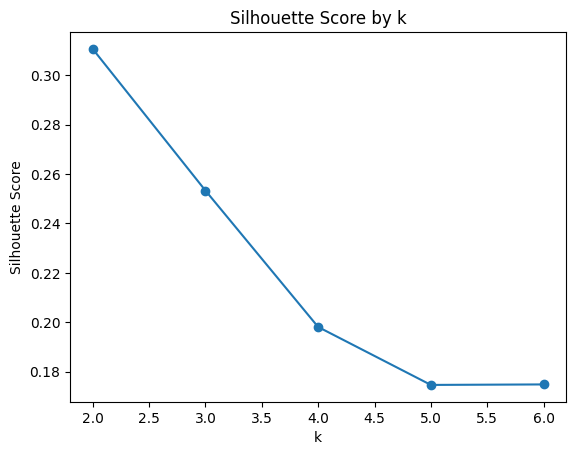

2

In [22]:
# find optimal k for home context
find_optimal_k(X_home)

In [23]:
kmeans_home = KMeans(n_clusters=2, random_state=123)
home_labels = kmeans_home.fit_predict(X_home)

# append the cluster labels to the 31Q dataset 
dat_final['HomeCluster'] = home_labels


### Social Environment 

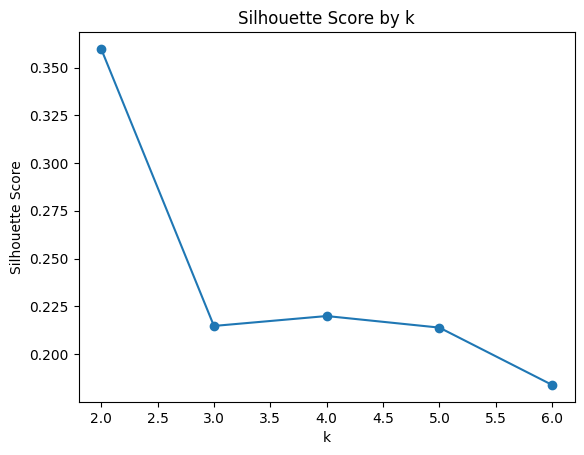

2

In [24]:
# find optimal k for home context
find_optimal_k(X_social)

In [25]:
kmeans_social = KMeans(n_clusters=2, random_state=123)
social_labels = kmeans_social.fit_predict(X_social)

# append the cluster labels to the 31Q dataset 
dat_final['SocialCluster'] = social_labels

### Phyiscal Health 

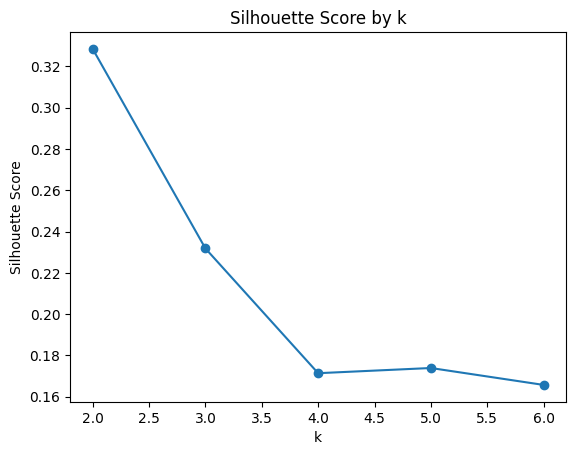

2

In [26]:
# find optimal k for home context
find_optimal_k(X_health)

In [27]:
kmeans_health= KMeans(n_clusters=2, random_state=123)
health_labels = kmeans_health.fit_predict(X_health)

# append the cluster labels to the 31Q dataset 
dat_final['HealthCluster'] = health_labels

## Label Direction Consistency Note


In this analysis, we performed clustering on three distinct domains: **Home Environment**, **Social Environment**, and **Physical Health**. Each domain was analyzed separately to identify clusters of individuals based on their responses to relevant survey questions. Importantly, we included **mental health indicators in all three clustering models** to serve as a **contextual anchor**. This allowed us to examine how patterns of environmental and social risk factors co-occur with mental health burden. By embedding mental health features into each domain-specific analysis, the resulting clusters reflect not only contextual adversity but also its psychological impact—enabling more meaningful interpretations of psychosocial vulnerability.

To ensure **consistent interpretation across domains**, we retrospectively **re-mapped the `SocialCluster` labels** so that:

- `Cluster 0` = **High-risk / High mental distress**
- `Cluster 1` = **Low-risk / Low mental distress**

This adjustment was necessary because KMeans assigns **arbitrary numeric labels** to clusters. In the original output, the `SocialCluster` labels were reversed in meaning compared to `HomeCluster` and `HealthCluster`—with `SocialCluster 0` reflecting the **low-risk group**. While there was no technical error, remapping the labels improves clarity and interpretability when comparing across domains.

### Cluster Reassignment for Domain Subsets

To reflect the new label direction, we reassigned cluster labels to the domain-specific DataFrames as follows:


In [28]:
# Recode the social cluster labels in dat_final
dat_final['SocialCluster'] = dat_final['SocialCluster'].map({0: 1, 1: 0})

## Cluster Evaluation and Domain Comparison

### Cluster Proportions

In [29]:
dat_final['HomeCluster'].value_counts(normalize=True)


HomeCluster
1    0.71531
0    0.28469
Name: proportion, dtype: float64

In [30]:
dat_final['SocialCluster'].value_counts(normalize=True)

SocialCluster
1    0.784744
0    0.215256
Name: proportion, dtype: float64

In [31]:
dat_final['HealthCluster'].value_counts(normalize=True)

HealthCluster
1    0.779202
0    0.220798
Name: proportion, dtype: float64

### Cluster Profile Means (Interpretation)

In [32]:
home_context['HomeCluster'] = dat_final['HomeCluster']
home_context.groupby('HomeCluster').mean()

,Q26,Q27,Q28,Q29,Q30,Q84,Q106,Q89,Q90,Q91,Q99,Q100,Q101,Q102,Q104
HomeCluster,,,,,,,,,,,,,,,
0,0.902290,0.679389,0.564122,1.543511,0.411069,3.813359,0.871756,3.166794,2.053435,1.885878,1.772137,0.627099,0.700763,0.376718,1.987405
1,0.246392,0.042534,0.027647,1.005469,0.004861,2.474404,0.324472,1.740544,1.252620,1.128209,1.401944,0.167857,0.185933,0.108309,1.653501


| Cluster | Suggested Label                         |
| ------- | --------------------------------------- |
| 0       | “**High-risk (Adverse) Home Environment & High Mental Distress**”  |
| 1       | “**Low-risk (Stable/Nurturing) Home Environment & Low Mental Distress**” |


In [33]:
social_context['SocialCluster'] = dat_final['SocialCluster']
social_context.groupby('SocialCluster').mean()

,Q26,Q27,Q28,Q29,Q30,Q84,Q106,Q14,Q16,Q19,Q20,Q21,Q22,Q23,Q24,Q25,Q88,Q103,Q105
SocialCluster,,,,,,,,,,,,,,,,,,,
0,0.929833,0.800606,0.684503,1.717819,0.541141,3.899041,0.891974,1.608279,1.745078,0.336699,1.806159,2.390712,2.146896,1.922766,0.474003,0.441696,0.273094,3.148915,0.345280
1,0.296871,0.065633,0.042094,1.005262,0.005123,2.569371,0.367350,1.133481,1.271531,0.024508,1.059540,2.008723,1.624481,1.387981,0.126835,0.093187,0.030324,2.460676,0.153559


| Cluster | Suggested Label                         |
| ------- | --------------------------------------- |
| 0       | “**Socially Isolated & High Mental Distress**”|
| 1       | “**Socially Supported & Low Mental Distress**” |


In [34]:
health_context['HealthCluster'] = dat_final['HealthCluster']
health_context.groupby('HealthCluster').mean()

,Q26,Q27,Q28,Q29,Q30,Q84,Q106,Q76,Q77,Q78,Q85
HealthCluster,,,,,,,,,,,
0,0.930610,0.888287,0.737205,1.709646,0.536909,3.894685,0.891732,4.550689,4.245079,3.301673,1.333661
1,0.292149,0.035560,0.022591,1.002510,0.002510,2.561149,0.363687,3.806303,3.892484,3.031097,0.720123


| Cluster | Suggested Label                                           |
| ------- | --------------------------------------------------------- |
| 0       | “**Low Phyisical Activity & High Mental Risk**” |
| 1       | “**High Phyisical Activity & Low Mental Risk**”   |


### Cluster Overlap Across Domains


In [35]:
pd.crosstab(dat_final['HomeCluster'], dat_final['SocialCluster'])

SocialCluster,0,1
HomeCluster,,
0,1782,838
1,199,6384


In [36]:
pd.crosstab(dat_final['HomeCluster'], dat_final['HealthCluster'])

HealthCluster,0,1
HomeCluster,,
0,1868,752
1,164,6419


In [37]:
pd.crosstab(dat_final['SocialCluster'], dat_final['HealthCluster'])

HealthCluster,0,1
SocialCluster,,
0,1679,302
1,353,6869


### Average Within-Cluster Distances

In [38]:
def average_within_cluster_distance(X, labels):
    dists = []
    for c in np.unique(labels):
        members = X[labels == c]
        dist = pairwise_distances(members).mean()
        dists.append(dist)
    return dists

average_within_cluster_distance(X_home, dat_final['HomeCluster'].values)


[np.float64(6.116005923163751), np.float64(3.7991367592332437)]

In [39]:
average_within_cluster_distance(X_social, dat_final['SocialCluster'].values)    


[np.float64(8.163594571806275), np.float64(4.155247993587591)]

In [40]:
average_within_cluster_distance(X_health, dat_final['HealthCluster'].values)

[np.float64(4.889349032369745), np.float64(3.5703869056265694)]

## Visualizations & Tables

### Cluster PCA Plots

In [41]:
def plot_clusters(X, labels, title='', label_desc=None):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    var_ratio = pca.explained_variance_ratio_ * 100

    # Compute label proportions
    proportions = pd.Series(labels).value_counts(normalize=True).sort_index()

    # Map cluster labels to descriptive names
    label_names = {
        0: f"Cluster 0: {label_desc[0]} ({proportions[0]:.1%})",
        1: f"Cluster 1: {label_desc[1]} ({proportions[1]:.1%})"
    }
    labeled_series = pd.Series(labels).map(label_names)

    # Plot
    custom_palette = ['#2c3e50', '#a3b18a']
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labeled_series, palette=custom_palette)
    plt.title(title)
    plt.xlabel(f'PC1 ({var_ratio[0]:.1f}% variance)')
    plt.ylabel(f'PC2 ({var_ratio[1]:.1f}% variance)')
    plt.legend(title='Cluster')
    plt.tight_layout()
    plt.show()



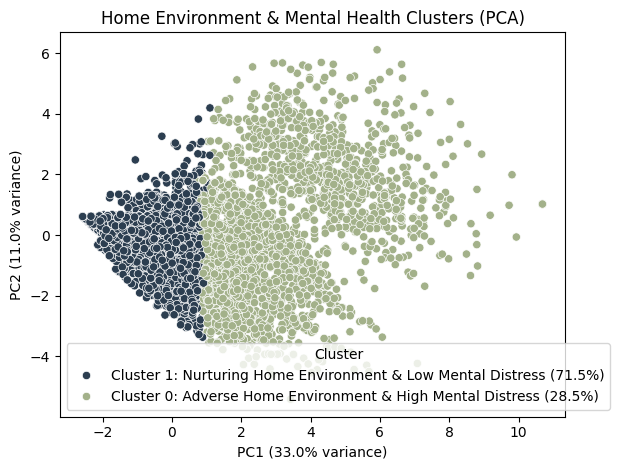

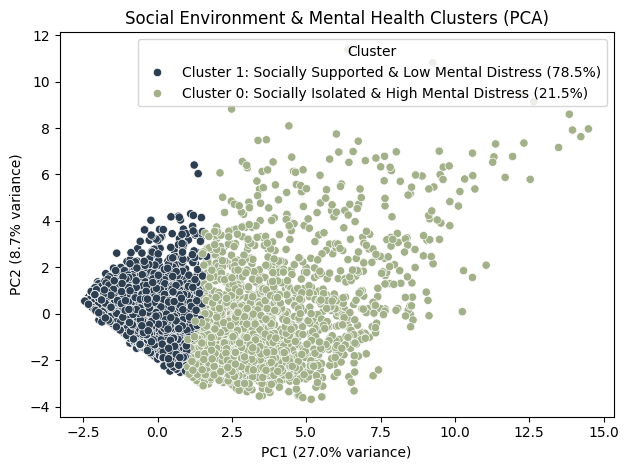

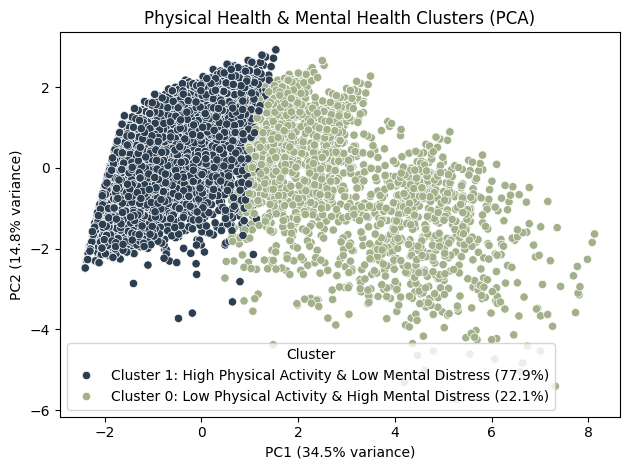

In [42]:
plot_clusters(
    X_home,
    dat_final['HomeCluster'],
    title='Home Environment & Mental Health Clusters (PCA)',
    label_desc=[
        'Adverse Home Environment & High Mental Distress',
        'Nurturing Home Environment & Low Mental Distress'
    ]
)

plot_clusters(
    X_social,
    dat_final['SocialCluster'],
    title='Social Environment & Mental Health Clusters (PCA)',
    label_desc=[
        'Socially Isolated & High Mental Distress',
        'Socially Supported & Low Mental Distress'
    ]
)

plot_clusters(
    X_health,
    dat_final['HealthCluster'],
    title='Physical Health & Mental Health Clusters (PCA)',
    label_desc=[
        'Low Physical Activity & High Mental Distress',
        'High Physical Activity & Low Mental Distress'
    ]
)


### Cluster Overlap Heatmap

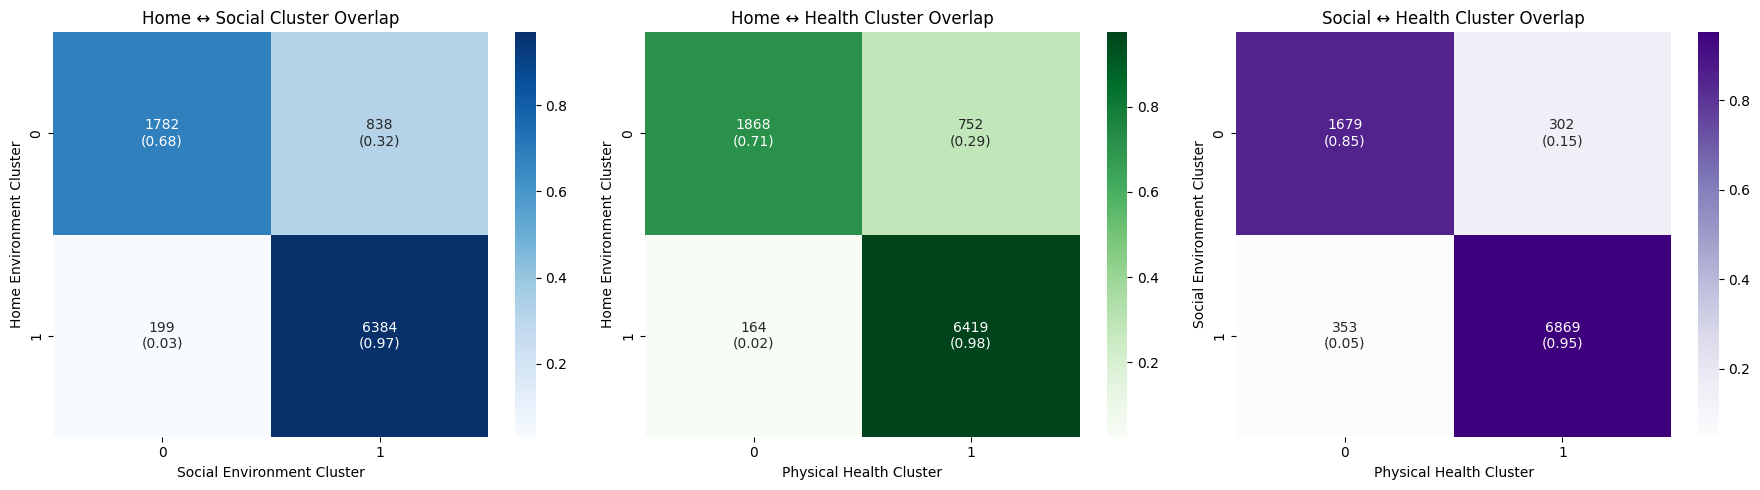

In [43]:
# Helper function to create annotations
def make_annotated_heatmap(row_var, col_var):
    counts = pd.crosstab(dat_final[row_var], dat_final[col_var])
    props = pd.crosstab(dat_final[row_var], dat_final[col_var], normalize='index')
    annotations = counts.astype(str) + "\n(" + props.round(2).astype(str) + ")"
    return props, annotations

# Prepare all three annotated heatmaps
ct_home_social, ann_home_social = make_annotated_heatmap('HomeCluster', 'SocialCluster')
ct_home_health, ann_home_health = make_annotated_heatmap('HomeCluster', 'HealthCluster')
ct_social_health, ann_social_health = make_annotated_heatmap('SocialCluster', 'HealthCluster')

# Plot side-by-side
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Home vs Social
sns.heatmap(ct_home_social, annot=ann_home_social, fmt='', cmap='Blues', ax=axes[0])
axes[0].set_title('Home ↔ Social Cluster Overlap')
axes[0].set_xlabel('Social Environment Cluster')
axes[0].set_ylabel('Home Environment Cluster')

# Home vs Health
sns.heatmap(ct_home_health, annot=ann_home_health, fmt='', cmap='Greens', ax=axes[1])
axes[1].set_title('Home ↔ Health Cluster Overlap')
axes[1].set_xlabel('Physical Health Cluster')
axes[1].set_ylabel('Home Environment Cluster')

# Social vs Health
sns.heatmap(ct_social_health, annot=ann_social_health, fmt='', cmap='Purples', ax=axes[2])
axes[2].set_title('Social ↔ Health Cluster Overlap')
axes[2].set_xlabel('Physical Health Cluster')
axes[2].set_ylabel('Social Environment Cluster')

plt.tight_layout()
plt.show()


### Silhouette Plots

In [44]:
custom_palette = ['#2c3e50', '#a3b18a']
def plot_silhouette(X, labels, title='Silhouette Plot'):
    silhouette_vals = silhouette_samples(X, labels)
    avg_score = silhouette_score(X, labels)
    n_clusters = len(np.unique(labels))

    fig, ax = plt.subplots(figsize=(6, 4))
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_vals = silhouette_vals[labels == i]
        ith_cluster_vals.sort()
        size_cluster_i = ith_cluster_vals.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = custom_palette[i]

        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_vals, facecolor=color, edgecolor='gray', alpha=0.7)
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, f'Cluster {i}')
        y_lower = y_upper + 10

    ax.axvline(x=avg_score, color="red", linestyle="--")
    ax.set_title(f"{title}\nAvg Silhouette Score: {avg_score:.2f}")
    ax.set_xlabel("Silhouette Coefficient")
    ax.set_ylabel("Clustered Samples")
    ax.set_xlim([-0.1, 1])
    plt.tight_layout()
    plt.show()

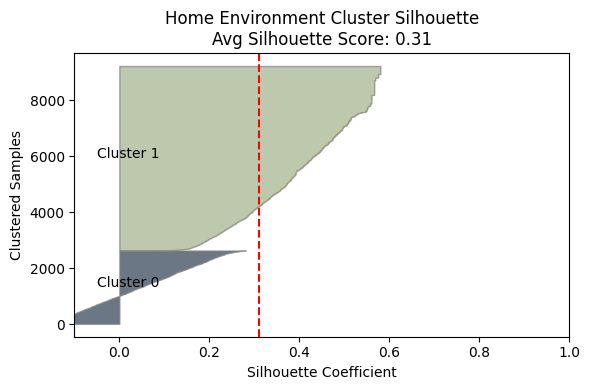

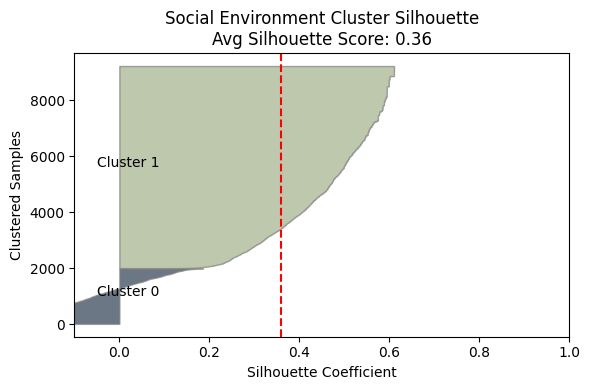

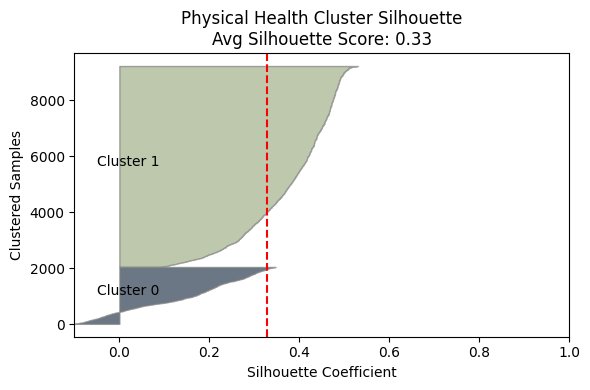

In [45]:
plot_silhouette(X_home, dat_final['HomeCluster'], title='Home Environment Cluster Silhouette')
plot_silhouette(X_social, dat_final['SocialCluster'], title='Social Environment Cluster Silhouette')
plot_silhouette(X_health, dat_final['HealthCluster'], title='Physical Health Cluster Silhouette')


### Cluster Summary Table

In [46]:
def cluster_summary(domain_name, labels, X, dists, label_desc):
    counts = pd.Series(labels).value_counts(normalize=True).sort_index() * 100
    sil_score = silhouette_score(X, labels)
    return {
        'Domain': domain_name,
        'Cluster 0 Size (%)': f"{counts[0]:.1f}%",
        'Cluster 1 Size (%)': f"{counts[1]:.1f}%",
        'Avg Dist (C0)': round(dists[0], 2),
        'Avg Dist (C1)': round(dists[1], 2),
        'Silhouette Score': round(sil_score, 3),
        'Label C0': label_desc[0],
        'Label C1': label_desc[1]
    }


summary_rows = []

summary_rows.append(cluster_summary(
    'Home',
    dat_final['HomeCluster'],
    X_home,
    average_within_cluster_distance(X_home, dat_final['HomeCluster'].values),
    ['Adverse Home Environment & High Mental Distress', 'Nurturing Home Environment & Low Mental Distress']
))

summary_rows.append(cluster_summary(
    'Social',
    dat_final['SocialCluster'],
    X_social,
    average_within_cluster_distance(X_social, dat_final['SocialCluster'].values),
    ['Socially Isolated & High Mental Distress', 'Socially Supported & Low Mental Distress']
))

summary_rows.append(cluster_summary(
    'Health',
    dat_final['HealthCluster'],
    X_health,
    average_within_cluster_distance(X_health, dat_final['HealthCluster'].values),
    ['Low Physical Activity & High Mental Distress', 'High Physical Activity & Low Mental Distress']
))

summary_df = pd.DataFrame(summary_rows)
summary_df

,Domain,Cluster 0 Size (%),Cluster 1 Size (%),Avg Dist (C0),Avg Dist (C1),Silhouette Score,Label C0,Label C1
0,Home,28.5%,71.5%,6.12,3.80,0.311,Adverse Home Environment & High Mental Distress,Nurturing Home Environment & Low Mental Distress
1,Social,21.5%,78.5%,8.16,4.16,0.360,Socially Isolated & High Mental Distress,Socially Supported & Low Mental Distress
2,Health,22.1%,77.9%,4.89,3.57,0.329,Low Physical Activity & High Mental Distress,High Physical Activity & Low Mental Distress


#### From CHAT GPT 

We conducted clustering across three domains—Home Environment, Social Environment, and Physical Health—to identify distinct psychosocial profiles based on survey responses. In each domain, two clusters emerged: one representing adverse conditions coupled with high mental distress, and the other reflecting nurturing or stable environments associated with low distress.

Notably, the majority of participants fell into the low-risk/low-distress cluster across all domains (Cluster 1: 71.5% in Home, 78.5% in Social, and 77.9% in Health), while the high-risk clusters (Cluster 0) were smaller but exhibited greater within-cluster variability, particularly in the Social domain (average distance = 8.16). This suggests that while high-risk individuals form a minority, their profiles are more diverse—especially in terms of social stress and support. These patterns support a dimensional model of vulnerability, where mental health distress co-occurs with distinct contextual adversities.

## Domain Specific Clustering Quality Analysis Conclusion

#### The clustering metrics look decent because:

- You have clear separation in the PCA space (the scatter plots show distinct clusters)
- The mathematical distances between cluster centers are reasonable
- Cluster sizes are fairly balanced (around 70-30 split)

#### But the clustering quality is actually poor because:

- **High overlap across domains**: Your confusion matrices show that the same individuals often belong to different clusters depending on which domain you're analyzing
- **Inconsistent cluster membership**: Someone might be in the "high risk" cluster for home environment but "low risk" cluster for health
- **Low silhouette score (0.31)**: This was actually telling you the truth - many data points are ambiguous in their cluster assignment

#### What this means:

Your clustering is capturing some real patterns in the data, but these patterns don't create clean, stable groups of people. Instead, you have individuals who might struggle in one domain (like home environment) but do well in others (like social connections).

This suggests that rather than having distinct "types" of people, your population might be better characterized by:

- Continuous risk gradients rather than discrete groups
- Domain-specific interventions rather than person-level classifications
- Multiple overlapping risk profiles rather than clear subtypes

# ------ MOVING FORWARD ------

# Working with Full Dataset

#### Data Exploration

In [47]:
# Count missing values per column
missing_summary = dat.isnull().sum().sort_values(ascending=False)

# Percentage missing per column
missing_pct = (dat.isnull().mean() * 100).sort_values(ascending=False)

# Preview top 10 most missing
print(missing_summary.head(10))
print(missing_pct.head(10))

QN34        19580
QN37        17457
QN45        17077
QNDUALBC    16659
QNBCNONE    16614
QNOTHHPL    16614
QNIUDIMP    16614
QN62        16614
QN60        16526
QN61        16194
dtype: int64
QN34        97.398398
QN37        86.837785
QN45        84.947520
QNDUALBC    82.868229
QNBCNONE    82.644381
QNOTHHPL    82.644381
QNIUDIMP    82.644381
QN62        82.644381
QN60        82.206636
QN61        80.555141
dtype: float64


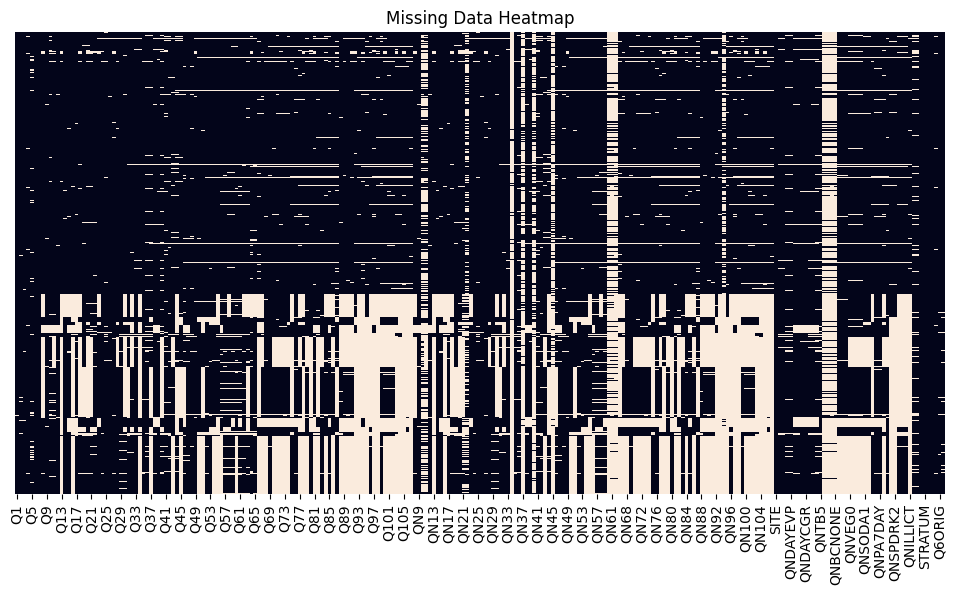

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(dat.isnull(), cbar=False, yticklabels=False)
plt.title("Missing Data Heatmap")
plt.show()

In [49]:
# Calculate percentage missing per column
missing_pct = dat.isnull().mean() * 100

# Filter columns with >50% missing
high_missing = missing_pct[missing_pct > 50].sort_values(ascending=False)

# Display them
print(f"{len(high_missing)} columns have more than 50% missing:\n")
print(high_missing)

14 columns have more than 50% missing:

QN34        97.398398
QN37        86.837785
QN45        84.947520
QNDUALBC    82.868229
QN62        82.644381
QNIUDIMP    82.644381
QNOTHHPL    82.644381
QNBCNONE    82.644381
QN60        82.206636
QN61        80.555141
QN40        78.426106
QN94        72.680694
QN11        59.861712
QN10        57.339701
dtype: float64


In [50]:
# Calculate percentage missing per column
missing_pct = dat.isnull().mean() * 100

# Filter columns with >40% missing
high_missing = missing_pct[missing_pct > 40].sort_values(ascending=False)

# Display them
print(f"{len(high_missing)} columns have more than 50% missing:\n")
print(high_missing)

43 columns have more than 50% missing:

QN34        97.398398
QN37        86.837785
QN45        84.947520
QNDUALBC    82.868229
QNBCNONE    82.644381
QNOTHHPL    82.644381
QNIUDIMP    82.644381
QN62        82.644381
QN60        82.206636
QN61        80.555141
QN40        78.426106
QN94        72.680694
QN11        59.861712
QN10        57.339701
Q105        47.356116
QN105       47.356116
QN98        46.336368
Q98         46.336368
Q107        46.301547
QN107       46.301547
Q104        46.027956
QN104       46.027956
QNILLICT    45.654877
Q106        45.550415
QN106       45.550415
Q93         44.431179
QN93        44.431179
Q103        44.401333
QN103       44.401333
Q97         44.301845
QN97        44.301845
Q94         43.625330
Q13         43.421380
QN13        43.421380
QN22        42.759787
QN16        42.038502
Q16         42.038502
QN66        41.327165
Q66         41.327165
QN95        40.760086
Q95         40.760086
QNSPDRK1    40.760086
QNSPDRK2    40.760086
dtype: float64

#### Missingness and Dropping QN# and QNword columns

In [51]:
# Step 1: Drop all QN# and QNword columns
qn_cols = [col for col in dat.columns if col.startswith('QN')]
dat2_step1 = dat.drop(columns=qn_cols)

# Step 2: Drop rows with any remaining missing values
dat2_cleaned = dat2_step1.dropna().copy()

print(f"Final shape of dat2_cleaned: {dat2_cleaned.shape}")

Final shape of dat2_cleaned: (6911, 115)


#### Recoding

•	Directional Binary\
•	Directional Reverse-Score (Ordinal)\
•	Neutral Numeric\
•	One-Hot\
•	Special Cases

14, 16, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 76, 77, 78, 84, 85, 88, 89, 90, 91, 99, 100, 101, 102, 103, 104, 105, 106

In [52]:
# Set working dataframe:
dat2_final = dat2_cleaned.copy()

# set as int


In [53]:
dat2_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6911 entries, 1 to 11426
Columns: 115 entries, Q1 to Q7ORIG
dtypes: float64(105), int64(2), object(8)
memory usage: 6.1+ MB


###### Binary

In [54]:
## Using function from above!

binary_cols_dat2 = [
    'Q4', 'Q18', 'Q19', 'Q24', 'Q25', 'Q26', 'Q27', 'Q28', 'Q31',
    'Q35', 'Q88', 'Q100', 'Q101', 'Q102', 'Q105', 'Q106'
]

dat2_final = binary_recode(dat2_final, binary_cols_dat2)

###### Directional – Ordinal (Reverse-Score)

In [55]:
## Using function from above!

ordinal_cols_dat2 = [
    'Q8', 'Q76', 'Q77', 'Q78', 'Q96', 'Q97', 'Q99', 'Q104'
]

dat2_final = reverse_recode(dat2_final, ordinal_cols_dat2)

###### Neutral Numeric

In [56]:
# Neutral Numeric

def numeric_recode(df, numeric_cols_dat2):
    df = df.copy()
    for col in numeric_cols_dat2:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').astype(int)
    return df

numeric_cols_dat2 = ['Q1', 'Q3']

dat2_final = numeric_recode(dat2_final, numeric_cols_dat2)

###### One-Hot Encoding

In [57]:
# One-Hot Encoding

# Quick pre-procesing for Q64: collapse all values other than 1–3 to 4 ("Other")
dat2_final['Q64'] = pd.to_numeric(dat2_final['Q64'], errors='coerce')
dat2_final['Q64'] = dat2_final['Q64'].apply(lambda x: x if x in [1, 2, 3] else 4)

# Q2, Q63, Q64, Q67 → standard one-hot encoding
def one_hot_recode(df, cols):
    df = df.copy()
    return pd.get_dummies(df, columns=cols, prefix=cols, dtype=int)

# Q5 → Multi-hot encoding for race codes A–E
def race_recode(df):
    df = df.copy()
    df['Q5'] = df['Q5'].astype(str).str.replace(" ", "")  # remove spaces

    letter_to_num = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5}
    
    for letter, num in letter_to_num.items():
        df[f'Q5_{num}'] = df['Q5'].apply(lambda x: int(letter in x))
    
    return df

In [58]:
# Recode Q5 (Race)
dat2_final = race_recode(dat2_final)
dat2_final.drop(columns='Q5', inplace=True)

# One-hot encode Q2, Q63, Q64, Q67
onehot_cols = ['Q2', 'Q63', 'Q64', 'Q67']
dat2_final = one_hot_recode(dat2_final, onehot_cols)

###### Special Cases

In [59]:
# Special case 1. Recoding map: 1, 3, 2
special1_map = {1: 0, 3: 1, 2: 2}

# Apply map to each special case column
for col in ['Q30', 'Q60', 'Q94']:
    if col in dat2_final.columns:
        dat2_final[col] = dat2_final[col].astype(int).map(special1_map)

In [60]:
# Special case 2. Age-of-first-use questions: 1, 7, 6, 5, 4, 3, 2, 1
special2_map = {1: 0, 2: 6, 3: 5, 4: 4, 5: 3, 6: 2, 7: 1}

for col in ['Q32', 'Q41', 'Q47', 'Q57']:
    if col in dat2_final.columns:
        dat2_final[col] = dat2_final[col].astype(int).map(special2_map).fillna(0).astype(int)

In [61]:
# Special case 3. Custom risk scale for birth control use: birth control = 1, no bc = 2, no sexual intercourse = 0
special3_map = {1: 0, 3: 1, 4: 1, 5: 1, 6: 1, 2: 2, 7: 2, 8: 2}

if 'Q62' in dat2_final.columns:
    dat2_final['Q62'] = dat2_final['Q62'].astype(int).map(special3_map)

In [62]:
# Special case 4. Custom Binary: transgender = 1, everything else = 0
special4_map = {2: 1, 1: 0, 3: 0, 4: 0}

if 'Q65' in dat2_final.columns:
    dat2_final['Q65'] = dat2_final['Q65'].astype(int).map(special4_map)

In [63]:
# Special case 5. U-shaped risk scale for weight perception: extremes are marked as higher risk
special5_map = {1: 2, 2: 1, 3: 0, 4: 1, 5: 2}

if 'Q66' in dat2_final.columns:
    dat2_final['Q66'] = dat2_final['Q66'].astype(int).map(special5_map)

In [64]:
# Special case 6. Reverse binary logic: testing = 0 (low risk), everything else = 1
special6_map = {1: 0, 2: 1, 3: 1}

for col in ['Q81', 'Q82']:
    if col in dat2_final.columns:
        dat2_final[col] = dat2_final[col].astype(int).map(special6_map)

In [65]:
# Special case 7. Custom risk scale for dental checkup
special7_map = {1: 0, 2: 1, 3: 2, 4: 3, 5: 3}

if 'Q83' in dat2_final.columns:
    dat2_final['Q83'] = dat2_final['Q83'].astype(int).map(special7_map)

In [66]:
# Special case 8. U-shaped sleep risk score: extremes are marked as higher risk
special8_map = {1: 3, 2: 2, 3: 1, 4: 0, 5: 0, 6: 0, 7: 1}

if 'Q85' in dat2_final.columns:
    dat2_final['Q85'] = dat2_final['Q85'].astype(int).map(special8_map)

In [67]:
# Special case 9. Sleeping situation housing risk: instability is marked as higher risk, on a scale
special9_map = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 3}

if 'Q86' in dat2_final.columns:
    dat2_final['Q86'] = dat2_final['Q86'].astype(int).map(special9_map)

In [68]:
# Special case 10. Academic performance — lower grades = higher risk (Q87)
special10_map = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 3, 7: 3}

if 'Q87' in dat2_final.columns:
    dat2_final['Q87'] = dat2_final['Q87'].astype(int).map(special10_map)

###### Check Recoding

In [69]:
# Define all recoded columns you expect to verify (add/remove as needed)
columns_to_check = dat2_final.columns  # or a specific list if preferred

# Display value counts for each column
for col in columns_to_check:
    if col in dat2_final.columns:
        print(f"\n{col} value counts:")
        print(dat2_final[col].value_counts(dropna=False).sort_index())


Q1 value counts:
Q1
1       1
2       5
3     724
4    1725
5    1803
6    1748
7     905
Name: count, dtype: int64

Q3 value counts:
Q3
1    1752
2    1823
3    1689
4    1642
5       5
Name: count, dtype: int64

Q4 value counts:
Q4
0    5752
1    1159
Name: count, dtype: int64

Q6 value counts:
Q6
1.35 50.8041111111112212221122211211111111    1
1.35 56.7031111111111223412211133211115212    1
1.35 77.1121114111112212132112211211121111    1
1.37 49.9051111111112212112222211211121111    1
1.37 65.7741111111112212112222211211121111    1
                                             ..
55111111112212112222211211121111              2
55111111112212212222211211121111              1
55111111212112231111133141117811              1
55221111111232212211132121111111              1
55221111112212112222211211121111              1
Name: count, Length: 6632, dtype: int64

Q7 value counts:
Q7
100.2541111111112212212212211211121111111111111111111121111111    1
100.2551111111112212111222211211111111111

###### Dropping unused columns and Converting to integer

In [70]:
dat2_final = dat2_final.drop(columns= ['Q6', 'Q7','Q37', 'Q45', 'RACEETH', 'SITE', 'STRATUM', 'PSU', 'WEIGHT', 'BMIPCT', 'Q6ORIG', 'Q7ORIG'], errors='ignore') # check, should we drop any MORE columns?

In [71]:
dat2_final.isnull().sum().sort_values(ascending=False).head(10)

Q1     0
Q84    0
Q96    0
Q95    0
Q94    0
Q93    0
Q92    0
Q91    0
Q90    0
Q89    0
dtype: int64

In [72]:
# Step 1: Check for NaNs
nan_summary = dat2_final.isnull().sum()
print(nan_summary[nan_summary > 0])  # shows only columns with missing values

Series([], dtype: int64)


In [73]:
dat2_final = dat2_final.apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)

### Standardize the Data

In [74]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

In [75]:
# Make a copy to avoid touching original
X = dat2_final.copy()

# Standardize all features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Elbow Method and Silhouette Score Tests

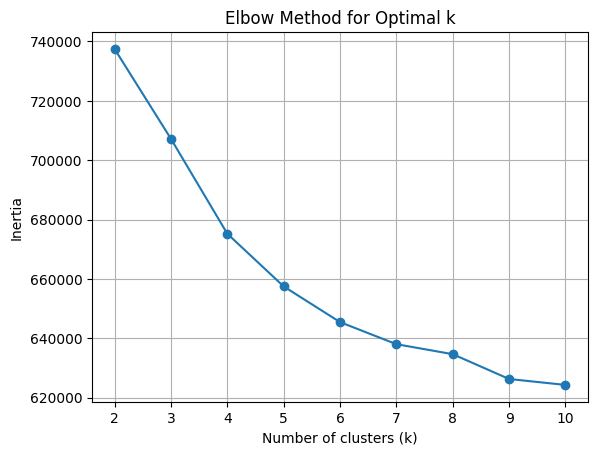

In [76]:
inertias = []
K = range(2, 11)  # Test 2 to 10 clusters

for k in K:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X_scaled)
    inertias.append(model.inertia_)

plt.plot(K, inertias, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

Interpretation from chat:

🔍 Elbow Method (Plot 1)\
	•	You’re plotting inertia (within-cluster sum of squares).\
	•	Goal: Find the point where the decrease in inertia slows down → that’s your “elbow”.\

Interpretation:\
	•	Inertia decreases steeply from k=2 to k=4\
	•	After k=4, the curve flattens, meaning adding more clusters doesn’t drastically reduce within-cluster distance\
	•	By k=6–7, the curve becomes very shallow\
    •	The "elbow" is most visible around k = 4 or k = 5

✅ Candidate: k = 5\
You could argue for 4 or 6 too, but 5 is the clearest “elbow.”

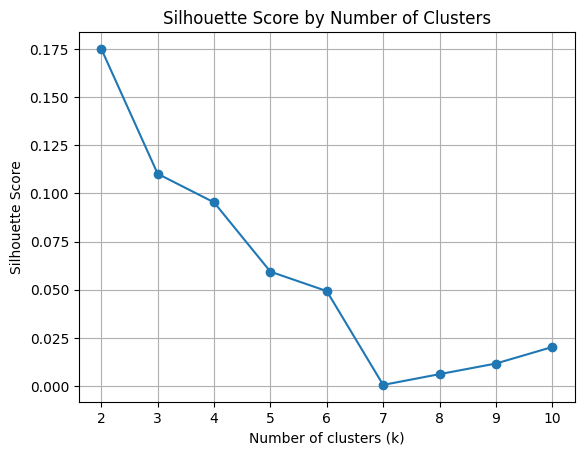

In [77]:
silhouette_scores = []
K = range(2, 11)

for k in K:
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

# Plot
plt.plot(K, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score by Number of Clusters')
plt.grid(True)
plt.show()

Interpretation from chat:

🔍 Silhouette Score (Plot 2)\
	•	You’re plotting the mean silhouette score (a measure of how well each point fits into its cluster).\
	•	Goal: Pick the k with the highest score.\
	
Interpretation:\
•	Peak score is at k = 2, with a value around 0.17: best-defined clustering structure.\
•	k = 3-4 also show relatively strong scores.\
•	k ≥ 5 shows rapid decline in silhouette scores, signaling weaker and less distinct clusters.\

✅ Candidate: k = 2 (strongest structure) or k = 4 (better nuance with acceptable separation)
Good cohesion/separation, but limited granularity.

#### ∴ our process will be:

•	We will run our analysis: k = 4

In [78]:
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to dataset
dat2_final['cluster'] = clusters

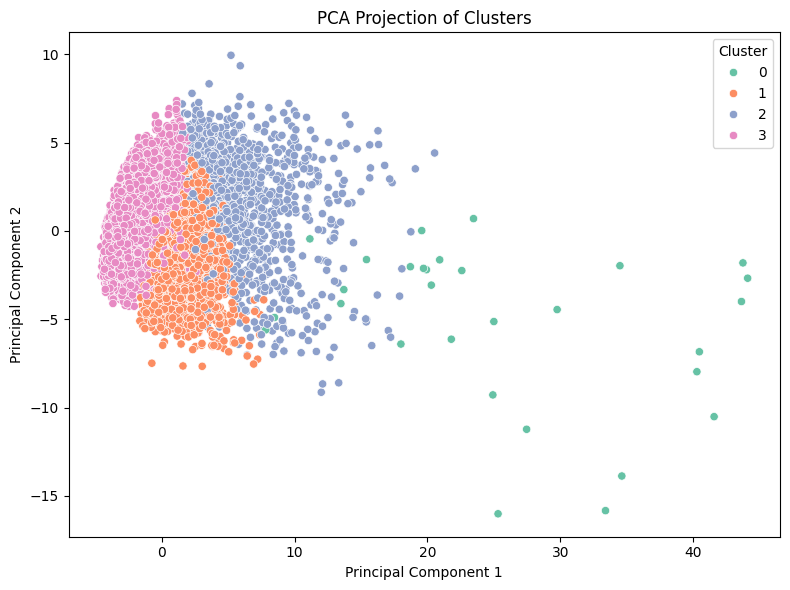

In [79]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette='Set2')
plt.title('PCA Projection of Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

In [80]:
cluster_profiles = dat2_final.groupby('cluster').mean()
display(cluster_profiles) # Average (mean) value of every feature within each cluster

,Q1,Q3,Q4,Q8,Q9,Q10,Q11,Q12,Q13,Q14,...,Q63_3.0,Q63_4.0,Q64_1.0,Q64_2.0,Q64_3.0,Q64_4.0,Q67_1.0,Q67_2.0,Q67_3.0,Q67_4.0
cluster,,,,,,,,,,,,,,,,,,,,,
0,5.366667,2.766667,0.266667,3.233333,3.133333,3.800000,4.900000,2.300000,2.100000,2.666667,...,0.233333,0.333333,0.600000,0.000000,0.166667,0.233333,0.400000,0.233333,0.066667,0.300000
1,5.600785,2.960733,0.166230,1.643979,1.240838,1.657723,2.817408,1.121073,1.085733,1.142016,...,0.360602,0.044503,0.837042,0.026178,0.081806,0.054974,0.384162,0.292539,0.163613,0.159686
2,5.298554,2.678719,0.180785,2.027893,1.638430,1.676653,2.715909,1.286157,1.175620,1.551653,...,0.370868,0.257231,0.505165,0.045455,0.285124,0.164256,0.609504,0.190083,0.079545,0.120868
3,4.805701,2.248119,0.164652,1.493957,1.196579,1.379475,1.672520,1.055188,1.032839,1.142987,...,0.061802,0.017104,0.760091,0.032839,0.095325,0.111745,0.449943,0.196807,0.147777,0.205473


### Cluster Evaluation

#### Summarize and Compare Cluster Profiles

In [81]:
# Attach cluster labels
dat2_final_with_clusters = dat2_final.copy()
dat2_final_with_clusters['Cluster'] = clusters

# Compute average values for each feature within each cluster
cluster_profiles = dat2_final_with_clusters.groupby("Cluster").mean().transpose()

display(cluster_profiles)

Cluster,0,1,2,3
Q1,5.366667,5.600785,5.298554,4.805701
Q3,2.766667,2.960733,2.678719,2.248119
Q4,0.266667,0.166230,0.180785,0.164652
Q8,3.233333,1.643979,2.027893,1.493957
Q9,3.133333,1.240838,1.638430,1.196579
...,...,...,...,...
Q67_1.0,0.400000,0.384162,0.609504,0.449943
Q67_2.0,0.233333,0.292539,0.190083,0.196807
Q67_3.0,0.066667,0.163613,0.079545,0.147777
Q67_4.0,0.300000,0.159686,0.120868,0.205473


#### Visualize the most distinctive features

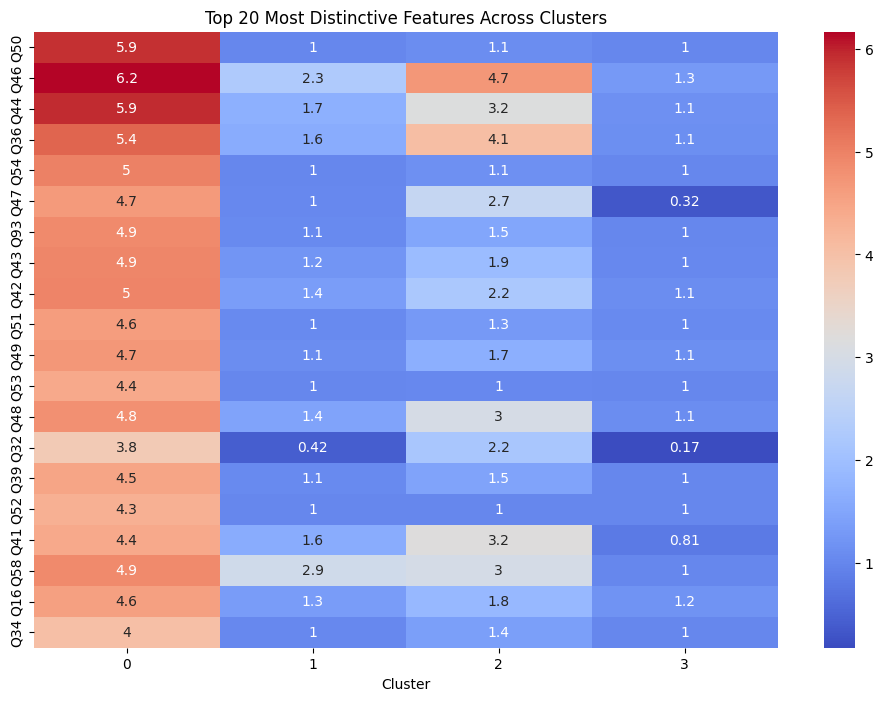

In [82]:
# Features with most variation across clusters
feature_variability = cluster_profiles.std(axis=1).sort_values(ascending=False)

top_features = feature_variability.head(20).index

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(cluster_profiles.loc[top_features], annot=True, cmap="coolwarm")
plt.title("Top 20 Most Distinctive Features Across Clusters")
plt.show()

### Cluster Interpretation

🟢 Cluster 0: High-Intensity Risk Takers

Suggested Label: “Early Initiators with High Lifetime and Current Risk Behaviors”\
	•	High average values across nearly all substance use variables: marijuana (Q46, Q48), alcohol (Q42–Q44), cocaine (Q50), ecstasy (Q54), meth (Q53), hallucinogens (Q93), and inhalants (Q51).\
	•	Started early: Low values on Q32 and Q41 (age of first cigarette and alcohol), meaning early initiation.\
	•	Frequent binge drinking and e-cigarette use (Q36, Q43, Q44).\
	•	Also high on Q58 (sexual partners) and Q16 (physical fights).

➡️ Interpretation: These are students engaging in multiple forms of high-risk behavior, often beginning at a young age. This is your “at-risk supercluster.”

🟡 Cluster 1: Moderate Users with Social Experimentation

Suggested Label: “Experimenters with Selective Use and Delayed Onset”\
	•	Some substance use, but lower frequency and later onset compared to Cluster 0.
	•	Lower risk drugs (like marijuana, alcohol) are present, but hard drugs like heroin, meth, and inhalants are much lower.\
	•	Fewer fights, fewer sexual partners.\
	•	Slightly elevated binge drinking or vaping in moderation.

➡️ Interpretation: This group appears to be experimenting but within “common” adolescent norms. Risk is present, but not deeply embedded or extreme.

🔵 Cluster 2: Low-Use, Delayed-Onset Students

Suggested Label: “Late-Onset or Minimal Risk Students”\
	•	Low scores across almost all substance use and violence variables.\
	•	Q32 and Q41 indicate late initiation or no initiation at all.\
	•	Lower than average risk behavior on Q16 (fights), Q58 (sexual partners), etc.

➡️ Interpretation: This group likely represents students who are either abstinent or engaged in minimal experimentation. Strong protective factors or conservative environments may be in play.

🔴 Cluster 3: Targeted Substance Users with Emotional Vulnerability

Suggested Label: “Alcohol and Marijuana Heavy Users with Emotional Risk”\
	•	Selective high use of substances like marijuana (Q46, Q48) and alcohol (Q42–Q44), but less widespread experimentation with hard drugs.\
	•	Often shows high recency (e.g., past 30-day usage) but not necessarily high lifetime use of all substances.\
	•	May co-occur with other emotional or mental health concerns based on additional features outside this top 20.

➡️ Interpretation: These students may be using substances as coping mechanisms, especially socially accepted ones like weed and alcohol. Possibly overlooked because their usage isn’t extreme in breadth, but still at risk.

#### Zooming in on Mental Health Risk-Related Variables Specifically:
In other words: ' given the students in Cluster 0, what's their average score on *sadness, suicidal ideation, cognitive difficulty*, etc?', so we can interpret clusters more deeply.

reminder, the mental health questions cover:

###### **26:** During the past 12 months, did you ever feel so sad or hopeless almost every day for two weeks or more in a row that you stopped doing some usual activities? = *prolonged sadness / hopelessness*
###### **27:** During the past 12 months, did you ever seriously consider attempting suicide? = *suicidal ideation*
###### **28:** During the past 12 months, did you make a plan about how you would attempt suicide? = *suicide planning*
###### **29:** During the past 12 months, how many times did you actually attempt suicide? = *suicide attempts*
###### **30:** If you attempted suicide during the past 12 months, did any attempt result in an injury, poisoning, or overdose that had to be treated by a doctor or nurse? = *suicide attempts requiring medical attention*
###### **84:** During the past 30 days, how often was your mental health not good? = *frequency of poor mental health / last month*
###### **106:** Because of a physical, mental, or emotional problem, do you have serious difficulty concentrating, remembering, or making decisions? = *cognitive difficulty due to mental health, emotional or physical issues*

In [83]:
mental_health_cols = ['Q26', 'Q27', 'Q28', 'Q29', 'Q30', 'Q84', 'Q106']
dat2_final.groupby('cluster')[mental_health_cols].mean()

,Q26,Q27,Q28,Q29,Q30,Q84,Q106
cluster,,,,,,,
0,0.733333,0.666667,0.600000,2.433333,0.966667,3.833333,0.800000
1,0.414267,0.166230,0.122382,1.056283,0.050393,2.721859,0.418194
2,0.845041,0.639463,0.542355,1.647727,0.488636,3.747934,0.827479
3,0.329532,0.141619,0.111060,1.054732,0.043330,2.708552,0.416420


So now, a fully rounded interpretation of each cluster (from chat):

##### Cluster 0: “High-Risk Substance Use & High Mental Distress”
•	🔥 Substance use cluster (you previously saw high averages for alcohol, marijuana, vaping, ecstasy, meth, etc.)\
•	😔 Mental health profile:\
•	Suicide ideation (Q27: 0.67), suicide plan (Q28: 0.60), attempts (Q29: 2.43, highest), treatment (Q30: 0.97)\
•	High sadness (Q26: 0.73), poor mental health (Q84: 3.83), cognitive difficulty (Q106: 0.80)\
•	📌 Interpretation: This group is experiencing severe emotional distress, multiple suicide indicators, and very high substance use — likely as coping. They’re a critical intervention group.

👉 Suggested Label:\
“At-Risk Supercluster: High Substance Use & Severe Mental Distress”

##### Cluster 1: “Moderate Risk, Socially Connected”
•	🌱 Earlier interpretation showed moderate social connection, moderate substance use, and fairly good grades.\
•	🧠 Mental health profile:\
•	Suicide ideation low (Q27: 0.17), plan (Q28: 0.12), attempts (Q29: 1.05), low treatment (Q30: 0.05)\
•	Sadness (Q26: 0.41), poor MH days (Q84: 2.72), cognitive difficulty (Q106: 0.42)\
•	📌 Interpretation: This group has some distress, but far lower risk than Cluster 0 or 2. They may have protective factors (e.g., family, school connection) keeping them more stable.

👉 Suggested Label:\
“Moderate Mental Distress with Protective Supports”

##### Cluster 2: “Low Belonging, High Internalizing”
•	🧍 Earlier features suggested isolation and conflict, lower connectedness, medium substance use.\
•	🧠 Mental health profile:\
•	Sadness (Q26: 0.85 — highest), suicide ideation (Q27: 0.64), plan (Q28: 0.54), attempts (Q29: 1.65), treatment (Q30: 0.49)\
•	Poor MH days (Q84: 3.75), cognitive difficulty (Q106: 0.83)\
•	📌 Interpretation: Although not as extreme on substance use, this group is emotionally distressed, lonely, and at risk of internalizing symptoms (depression, suicidality).

👉 Suggested Label:\
“Socially Isolated & High Internalizing Risk”

##### Cluster 3: “Low Risk, Emotionally Stable”
•	💡 This group had low substance use, lower aggression, good connectedness, and academic indicators.\
•	🧠 Mental health profile:\
•	All indicators are lowest: suicide ideation (Q27: 0.14), sadness (Q26: 0.33), poor MH days (Q84: 2.71), cognitive difficulty (Q106: 0.42)\
•	📌 Interpretation: This group shows strong protective factors and low distress. They are functioning well overall, likely benefiting from stable environments and support.

👉 Suggested Label:\
“Emotionally Well-Regulated & Low-Risk Group”

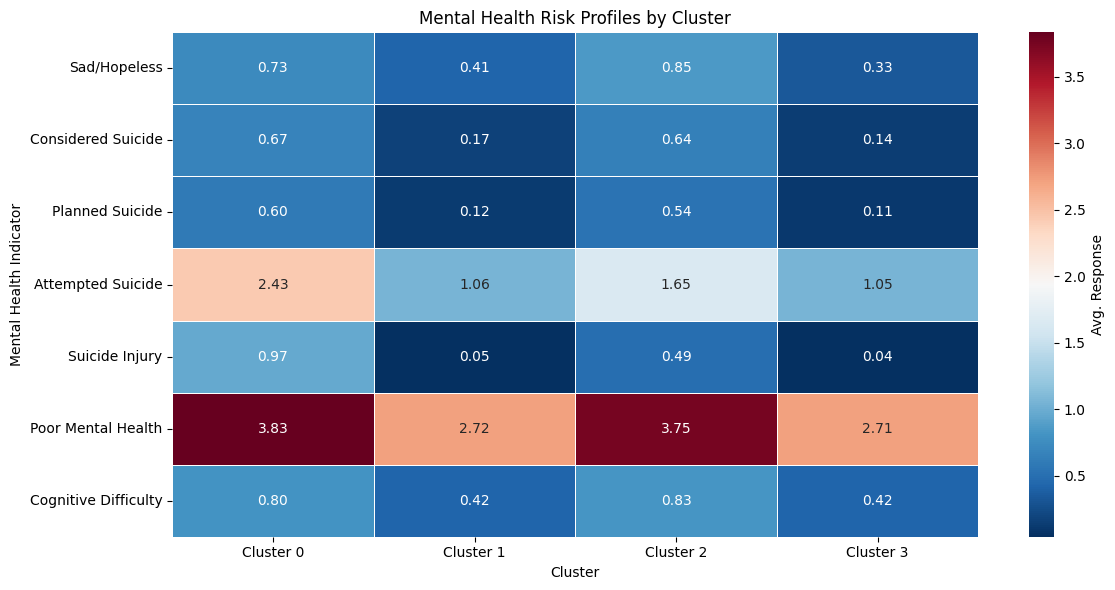

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Reconstruct the mental health data manually
cluster_mh = pd.DataFrame({
    'Q26': [0.733333, 0.414267, 0.845041, 0.329532],
    'Q27': [0.666667, 0.166230, 0.639463, 0.141619],
    'Q28': [0.600000, 0.122382, 0.542355, 0.111060],
    'Q29': [2.433333, 1.056283, 1.647727, 1.054732],
    'Q30': [0.966667, 0.050393, 0.488636, 0.043330],
    'Q84': [3.833333, 2.721859, 3.747934, 2.708552],
    'Q106': [0.800000, 0.418194, 0.827479, 0.416420]
}, index=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'])

# Optional: Rename questions for readability
cluster_mh.rename(columns={
    'Q26': 'Sad/Hopeless',
    'Q27': 'Considered Suicide',
    'Q28': 'Planned Suicide',
    'Q29': 'Attempted Suicide',
    'Q30': 'Suicide Injury',
    'Q84': 'Poor Mental Health',
    'Q106': 'Cognitive Difficulty'
}, inplace=True)

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    cluster_mh.T,               # transpose for questions on y-axis
    cmap='RdBu_r',              # diverging colormap
    annot=True, fmt=".2f",      # show values
    linewidths=0.5,
    cbar_kws={"label": "Avg. Response"}
)
plt.title("Mental Health Risk Profiles by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Mental Health Indicator")
plt.tight_layout()
plt.show()

##### Radar Plot

Each axis represents one of the seven mental health risk indicators.\
•	Values closer to the outer edge of the circle = higher average scores, which usually indicate greater mental distress or more frequent symptoms/behaviors.\
•	Values closer to the center = lower risk or symptom levels.

🔴 Cluster 0\
Archetype: “At-Risk Supercluster: High Substance Use & Severe Mental Distress”\
•	Highest scores across all indicators—especially Q29 (attempted suicide), Q84 (bad mental health days), and Q106 (cognitive difficulty).\
•	This is your highest-need group, and although it’s only 0.4% of the sample, it’s very high-risk and important to identify.

🟠 Cluster 1\
Archetype: “Moderate Mental Distress with Protective Supports”\
•	Mild to moderate scores, especially on Q26, Q29, Q84.\
•	Generally middle of the road, possibly students with support but occasional episodes of distress.

🟣 Cluster 2\
Archetype: “Socially Isolated, High Internalizing Risk (Suicidality)”\
•	Very high Q26 and Q27 scores (sadness and suicide ideation), moderate Q28 and Q29.\
•	Indicates chronic internal pain, even if not always acted upon physically.\
•	Should be flagged for early intervention, even though outward behavior may seem okay.

🩷 Cluster 3\
Archetype: “Emotionally Well-Regulated and Low-Risk”\
•	Lowest scores across all dimensions.\
•	Appears emotionally stable, low-risk, may represent students with healthy coping systems and support.\
•	This is your “baseline” group, making up over 60% of your sample.

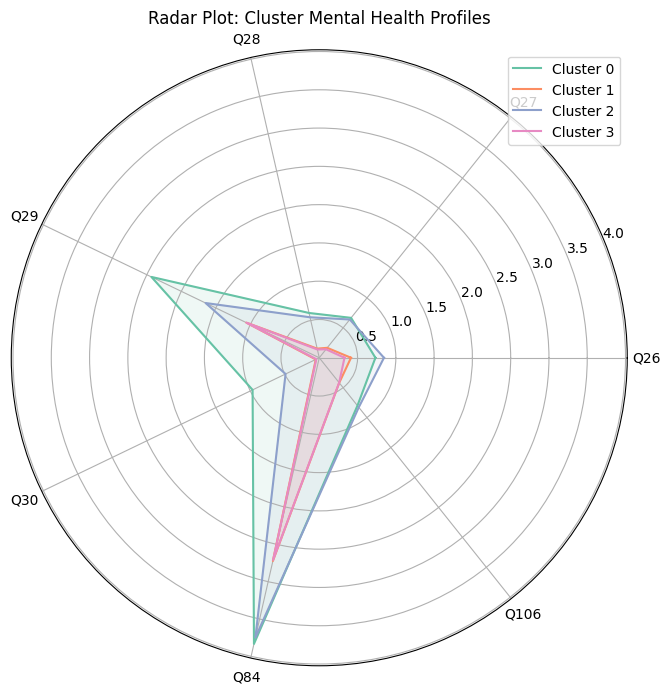

In [85]:
import numpy as np

labels = ['Q26', 'Q27', 'Q28', 'Q29', 'Q30', 'Q84', 'Q106']
cluster_means = dat2_final.groupby('cluster')[labels].mean()

angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']

for i, row in cluster_means.iterrows():
    values = row.tolist() + row.tolist()[:1]
    ax.plot(angles, values, label=f'Cluster {i}', color=colors[i])
    ax.fill(angles, values, alpha=0.1, color=colors[i])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
plt.title("Radar Plot: Cluster Mental Health Profiles")
plt.legend()
plt.show()

### Cluster Summary Table

In [86]:
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(dat2_final.drop(columns=['cluster']))
clusters = dat2_final['cluster']

In [87]:
from sklearn.metrics import silhouette_score

summary_rows = []
cluster_labels = [
            "At-Risk Supercluster: High Substance Use & Severe Mental Distress",
            "Moderate Mental Distress with Protective Supports",
            "Socially Isolated, High Internalizing Risk (Suicidality)",
            "Emotionally Well-Regulated and Low-Risk"
]
for i in range(4):
    cluster_data = dat2_final[dat2_final['cluster'] == i]
    size = len(cluster_data) / len(dat2_final) * 100
    centroid = kmeans.cluster_centers_[i]
    dists = np.linalg.norm(X_scaled[dat2_final['cluster'] == i] - centroid, axis=1)
    avg_dist = dists.mean()
    
    summary_rows.append({
        'Cluster': i,
        'Size (%)': round(size, 1),
        'Avg Dist to Centroid': round(avg_dist, 2),
        'Silhouette Score': round(silhouette_score(X_scaled, clusters), 3),  # same score for all
        'Archetype': cluster_labels[i]  # insert manually or define a list
    })

pd.DataFrame(summary_rows)


,Cluster,Size (%),Avg Dist to Centroid,Silhouette Score,Archetype
0,0,0.4,26.60,0.095,At-Risk Supercluster: High Substance Use & Sev...
1,1,22.1,9.58,0.095,Moderate Mental Distress with Protective Supports
2,2,14.0,13.49,0.095,"Socially Isolated, High Internalizing Risk (Su..."
3,3,63.4,8.32,0.095,Emotionally Well-Regulated and Low-Risk


To interpret table^

✅ What does Size % refer to?\
This tells you the percentage of the dataset that falls into each cluster. For example:\
	•	Cluster 0: 0.4% → Extremely rare but high risk\
	•	Cluster 3: 63% → Most common, possibly low-risk baseline

👉 Interpretation:
Rare clusters with extreme profiles may represent outliers, but in health and education, they often represent critical populations who need tailored intervention, despite their size.

✅ What does Avg Distance to Centroid mean?\
This is the average distance between all members of a cluster and that cluster’s centroid (i.e., its “center of gravity” in multi-dimensional space).\
	•	Smaller values = tighter cluster (more cohesive).\
	•	Larger values = more spread out (potentially noisier or more variable data within the cluster).

In your table:
	•	Cluster 0 has a very high average distance (26.60) → This suggests that while this group shares a high-risk profile, the individuals are more diverse in their responses.\
	•	Cluster 3 has a low average distance (8.32) → This group is more homogeneous or “tight” in their responses.

✅ What does Silhouette Score mean?\
The Silhouette Score measures how well each object lies within its cluster compared to others. It ranges from –1 to +1:\
	•	+1 → very well-clustered (tight and distinct)\
	•	0 → overlapping clusters (not clearly separated)\
	•	–1 → likely misclassified (closer to another cluster)

In your case:\
	•	All clusters have a silhouette score of ~0.095, which is low but not uncommon in high-dimensional, noisy social science data.\
	•	This means clusters are not super crisp, but they still show meaningful structure—especially when interpreted qualitatively (like you’re doing with archetypes).

##### Distances to Centroid by Cluster

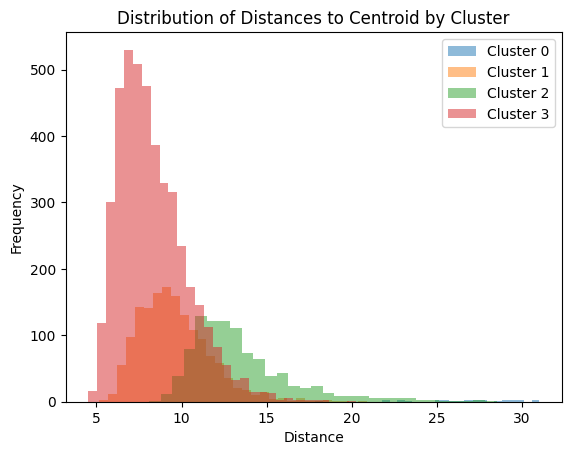

In [88]:
for i in range(4):
    cluster_data = X_scaled[dat2_final['cluster'] == i]
    dists = np.linalg.norm(cluster_data - kmeans.cluster_centers_[i], axis=1)
    plt.hist(dists, bins=30, alpha=0.5, label=f'Cluster {i}')
plt.legend()
plt.title("Distribution of Distances to Centroid by Cluster")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.show()

### Interpretation: Distribution of Distances to Cluster Centroids

- **Cluster 3 (Well-Regulated + Low-Risk)** shows the *tightest distribution*, with most members close to the centroid — suggesting *high internal consistency* and a well-defined profile.
- **Cluster 2 (Socially Isolated + Internalizing)** is moderately dispersed, indicating more variability in how internalizing symptoms manifest among members.
- **Cluster 1 (Moderate Distress + Supports)** is slightly more spread out, reflecting mixed characteristics — likely due to protective and risk factors coexisting within this group.
- **Cluster 0 (At-Risk Supercluster)** is the most *dispersed*, confirming its *heterogeneous and outlier-heavy nature*. These individuals differ from each other more than any other group.

This plot reinforces the reliability of the clusters — particularly that Cluster 3 is most stable, and Cluster 0 contains more unique, high-risk profiles.

#### Cluster Density Map

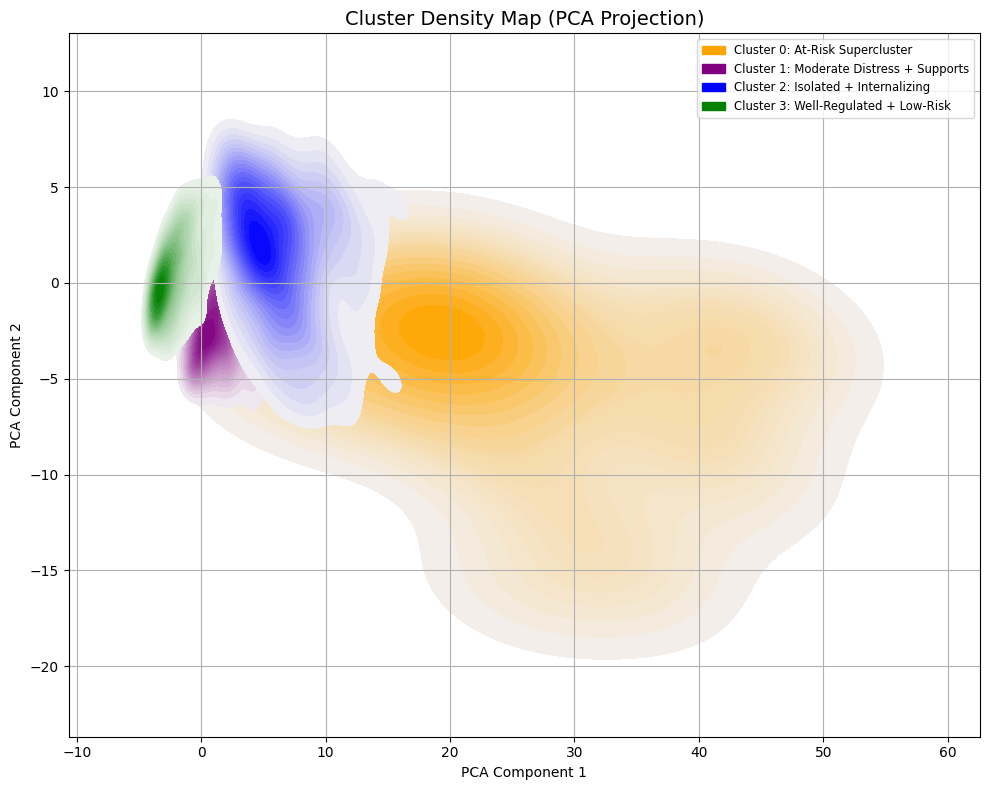

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn.decomposition import PCA

# Run PCA if you haven't already
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
dat2_final['PCA1'] = X_pca[:, 0]
dat2_final['PCA2'] = X_pca[:, 1]

# Plot KDEs with distinct colormaps
plt.figure(figsize=(10, 8))

# Define clearer color hues
colors = ['orange', 'purple', 'blue', 'green']
cmap_dict = {
    0: sns.light_palette("orange", as_cmap=True),
    1: sns.light_palette("purple", as_cmap=True),
    2: sns.light_palette("blue", as_cmap=True),
    3: sns.light_palette("green", as_cmap=True)
}

# Plot each cluster’s density with stronger alpha and no overlap blending
for i in range(4):
    cluster_data = dat2_final[dat2_final['cluster'] == i]
    sns.kdeplot(
        x=cluster_data['PCA1'],
        y=cluster_data['PCA2'],
        fill=True,
        alpha=1,
        thresh=0.05,
        levels=20,
        cmap=cmap_dict[i],
        label=f"Cluster {i}"
    )

# Add legend manually for better visibility
legend_labels = [
    "Cluster 0: At-Risk Supercluster",
    "Cluster 1: Moderate Distress + Supports",
    "Cluster 2: Isolated + Internalizing",
    "Cluster 3: Well-Regulated + Low-Risk"
]
patches = [Patch(color=colors[i], label=legend_labels[i]) for i in range(4)]
plt.legend(handles=patches, loc='upper right', fontsize='small')

# Label axes and show
plt.title('Cluster Density Map (PCA Projection)', fontsize=14)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.tight_layout()
plt.show()

SAME!! JUST DIFFERENT VISUAL.

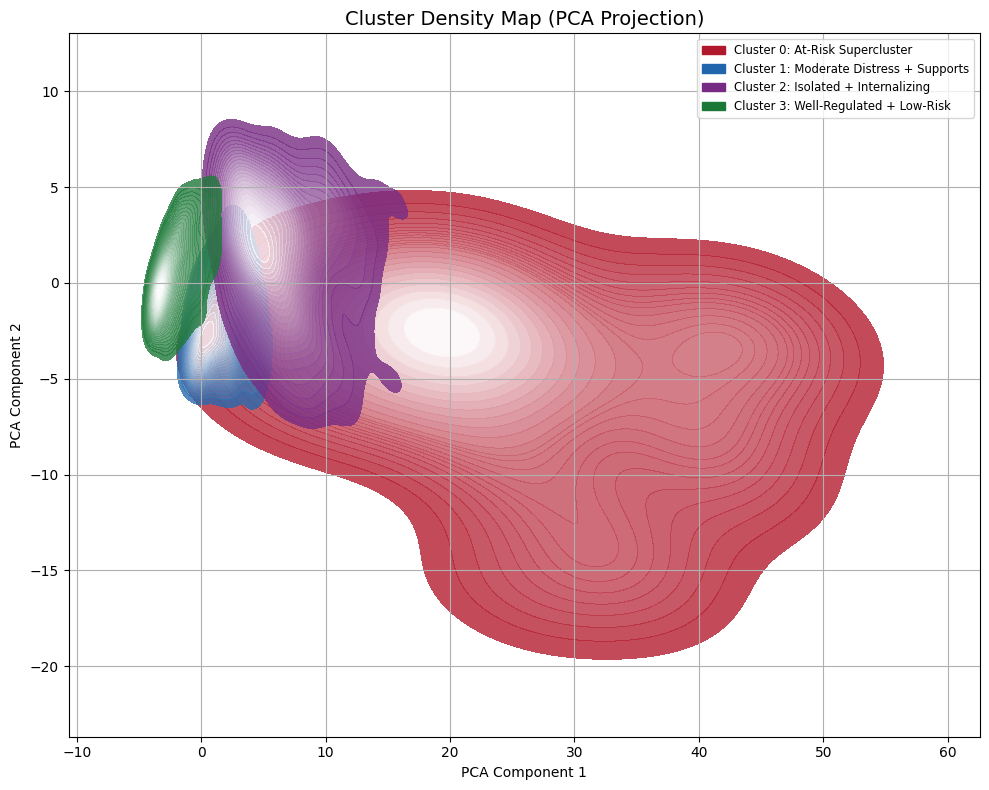

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch
from sklearn.decomposition import PCA

# --- Run PCA if you haven't already ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
dat2_final['PCA1'] = X_pca[:, 0]
dat2_final['PCA2'] = X_pca[:, 1]

# --- Define base colors for each cluster ---
base_colors = ['#b2182b', '#2166ac', '#762a83', '#1b7837']  # Red, Blue, Purple, Green

# --- Create custom colormaps that fade to white ---
def create_colormap(hex_color):
    return LinearSegmentedColormap.from_list(
        name=f'{hex_color}_fade',
        colors=[hex_color, '#ffffff'],
        N=256
    )

cmap_dict = {i: create_colormap(color) for i, color in enumerate(base_colors)}

# --- Plot the KDE cluster densities ---
plt.figure(figsize=(10, 8))
for i in range(4):
    cluster_data = dat2_final[dat2_final['cluster'] == i]
    sns.kdeplot(
        x=cluster_data['PCA1'],
        y=cluster_data['PCA2'],
        fill=True,
        cmap=cmap_dict[i],
        alpha=0.8,
        thresh=0.05,
        levels=25,
        label=f"Cluster {i}"
    )

# --- Add a custom legend ---
legend_labels = [
    "Cluster 0: At-Risk Supercluster",
    "Cluster 1: Moderate Distress + Supports",
    "Cluster 2: Isolated + Internalizing",
    "Cluster 3: Well-Regulated + Low-Risk"
]
patches = [Patch(color=base_colors[i], label=legend_labels[i]) for i in range(4)]
plt.legend(handles=patches, loc='upper right', fontsize='small')

# --- Final plot formatting ---
plt.title('Cluster Density Map (PCA Projection)', fontsize=14)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.tight_layout()
plt.show()

### Cluster Density Map Interpretation

- **Cluster 0 (_At-Risk Supercluster_)**  
  - Highly dispersed and loosely clustered, indicating *heterogeneity* among students with high-risk profiles.  
  - Occupies a distinct region of PCA space, far from other groups — supports its outlier nature.  
  - Visually confirms that this group is rare (low density) but extreme (spread over a wide area).

- **Cluster 1 (_Moderate Distress + Supports_)**  
  - Moderately compact with partial overlap into Cluster 3.  
  - Suggests that this group shares some traits with well-regulated peers but experiences *elevated distress*.  
  - Spread implies greater within-group variability than Cluster 3.

- **Cluster 2 (_Socially Isolated + Internalizing Risk_)**  
  - Very tight and dense, indicating a *cohesive and consistent* subtype.  
  - Spatially distinct from Cluster 3 despite similar behavioral restraint, supporting its uniqueness.  
  - Its location reinforces a profile marked by *internal struggle without external disruption*.

- **Cluster 3 (_Well-Regulated + Low-Risk_)**  
  - Most densely concentrated cluster, occupying a tight space in the PCA projection.  
  - Suggests high within-group similarity and a well-defined “low-risk” profile.  
  - Positioned farthest from the at-risk cluster, reinforcing its strong protective factors.

- **Overall Interpretation**  
  - The clusters are not only algorithmically distinct but *spatially and behaviorally meaningful*.  
  - This projection offers a nuanced, visual confirmation of the typologies identified — from low-risk to high-need extremes.

### Evaluation and Reliability Checks

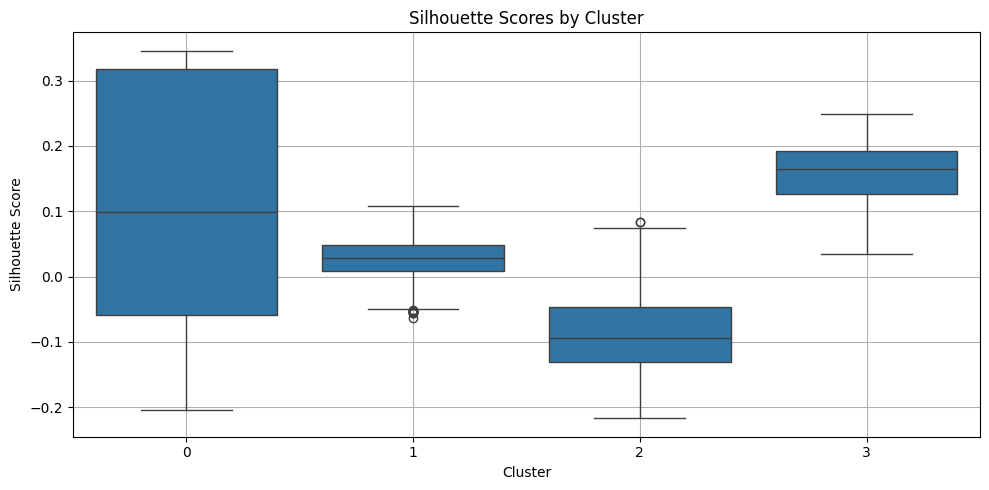

Average Silhouette Score: 0.095
Calinski-Harabasz Index: 454.73
Davies-Bouldin Index: 2.783


In [91]:
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Silhouette Scores per Sample
sample_silhouette_values = silhouette_samples(X_scaled, clusters)

plt.figure(figsize=(10, 5))
sns.boxplot(x=clusters, y=sample_silhouette_values)
plt.title('Silhouette Scores by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Average Silhouette Score (summary)
avg_sil_score = silhouette_score(X_scaled, clusters)
print(f"Average Silhouette Score: {avg_sil_score:.3f}")

# 3. Calinski-Harabasz Index
chi = calinski_harabasz_score(X_scaled, clusters)
print(f"Calinski-Harabasz Index: {chi:.2f}")

# 4. Davies-Bouldin Index
dbi = davies_bouldin_score(X_scaled, clusters)
print(f"Davies-Bouldin Index: {dbi:.3f}")

### Cluster Evaluation Summary

- **Cluster 3 (Well-Regulated + Low-Risk)** shows strong cohesion and separation, with high silhouette scores and low variance. It is the most reliable cluster.
- **Cluster 0 (At-Risk Supercluster)** is heterogeneous. Some members are tightly clustered, but others are loosely associated — likely due to the diverse risk profiles it captures.
- **Cluster 1 (Moderate Distress + Supports)** is reasonably defined, though the low silhouette score suggests some conceptual overlap with adjacent profiles.
- **Cluster 2 (Isolated + Internalizing)** is the least stable cluster, with many borderline or misclassified individuals, indicating the need for refinement or additional sub-clustering.

### Validation Metrics
- *Silhouette Score (0.095)*: Low global cohesion, but one or two well-formed clusters.
- *Calinski–Harabasz Index (454.73)*: Acceptable internal consistency and separation.
    - Measures cluster separation (between-cluster dispersion) vs cluster compactness (within-cluster variance).
    - Higher is better.
    - No upper bound — it depends on the dataset and number of clusters.
    - A CH Index > 100 is usually a sign of well-separated clusters for psychological data.

    ✅ Interpretation for Your Data:
    A score of 454.73 is very good for a social survey dataset with messy, overlapping constructs. It suggests that your clusters are meaningfully different in the multidimensional space (i.e., mental health, substance use, etc.).
- *Davies–Bouldin Index (2.783)*: Moderate overlap, room for cluster improvement.
    - Measures average similarity between each cluster and its most similar neighbor.
    - Lower is better.
    - A perfect score is 0.

    In real-world social data:
	•	DB ≈ 1–2 = strong
	•	DB ≈ 2–3 = moderate
	•	DB > 3 = weak clustering

    ✅ Interpretation for Your Data:
    A score of 2.783 suggests that clusters are distinct, but some (e.g., Cluster 2) show overlap or internal fuzziness. This matches your earlier findings — Cluster 0 and 3 are strong; Cluster 2 is ambiguous.


> While the overall clustering structure is moderate, Cluster 3 stands out as highly stable. Cluster 0 highlights the importance of identifying outlier-rich high-risk groups. Future work might explore sub-clusters or additional features to improve delineation.

> Cluster evaluation metrics indicate strong confidence in **Cluster 3 (Well-Regulated + Low-Risk)** and **Cluster 0 (At-Risk Supercluster)**. Cluster 3 shows high cohesion and clear separation in both PCA and silhouette scores. Cluster 0, while small, is highly distinct and dispersed—reflecting a heterogeneous group of high-risk outliers. **Cluster 1 (Moderate Distress + Supports)** lands in the middle: it’s reasonably defined but shows more internal variation, likely due to the coexistence of protective and risk factors. **Cluster 2 (Socially Isolated + Internalizing)** is the weakest—showing low silhouette scores and density overlap—suggesting it may represent a less cohesive, transitional profile that could benefit from refinement.

let us know if you have any questions!